## Avaliação em holdouts - Palco 2010

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from flurs.recommender import BPRMFRecommender, SketchRecommender
from eval_implicit import EvaluateHoldoutsFlurs

import pandas as pd
import numpy as np

from datetime import datetime
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

### BPRMF

In [4]:
# importa dataset 'palco playlists'
data = pd.read_csv('output/palco_2010_dump/sampled_palco2010.csv')
user_col = 'user_id'
item_col = 'track_id'

In [5]:
buckets = joblib.load('output/palco_2010_dump/sample_buckets.joblib')
holdouts = joblib.load('output/palco_2010_dump/sample_holdouts.joblib')

In [6]:
%%time
import itertools
from flurs.data.entity import User, Item, Event
def grid_search(model, data, user_col, item_col, exclude_known_items, N_recommendations=-1):    
#     try:
        usermap = pd.Series(pd.unique( data[user_col] )).reset_index().set_index(0).to_dict()['index']
        itemmap = pd.Series(pd.unique( data[item_col] )).reset_index().set_index(0).to_dict()['index']
        num_factors = [50, 100, 150, 200]
        regularization = [0.01, 0.05, 0.1, 0.25, 0.5]
        learn_rate = [0.01, 0.05, 0.1, 0.25, 0.5]
        grid = [num_factors, regularization, learn_rate]
        grid = list(itertools.product(*grid))
        results = []
        for i, hp in enumerate(grid):
            print(((i*100)/len(grid)), '%')
            nf, reg, lr = hp
            m = model(k=nf, l2_reg=reg, learn_rate=lr)     
            m.initialize()
            max_item_ID = 0
            empty_stream = ImplicitData([], []) # used to track items seen by users
            iteration_results = []
            for u, i in data[[user_col, item_col]].values:
                u_flurs, i_flurs = usermap[u], itemmap[i]
                max_item_ID = max(max_item_ID, i_flurs)
                user = User(u_flurs)
                item = Item(i_flurs)
                event = Event(user, item)
                m.register(user)
                m.register(item)
                # Prequential:
                # recommend
                reclist, scores = m.recommend(user, np.arange(max_item_ID+1) )                
#                 print(u_flurs, i_flurs, reclist[:10], scores[:10]) # 
                if exclude_known_items:
                    user_items = empty_stream.GetUserItems(u_flurs)
                    reclist = np.delete(reclist, user_items)
                # get n recommendations
                n = N_recommendations
                if n == -1:
                    n = len(reclist)
                reclist = reclist[:n]
                # evaluate
                result = 0
                if len(reclist) == 0:
                    iteration_results.append( 0 )
                else:
                    iteration_results.append( int(i_flurs in reclist) )
                # update
                empty_stream.AddFeedback(u_flurs, i_flurs) #
                m.update(event)

            results.append( np.mean( iteration_results ) )
#             print ( np.mean( iteration_results ), len( iteration_results ))
            
        return grid, results    
    
#     except:
#         print(u, i, u_flurs, i_flurs, max_item_ID, user, item, user_items)

prop = 0.05
hp_sample = data.iloc[:round( data.shape[0]*prop )]
# 4h 17min 22s
grid, results = grid_search(model=BPRMFRecommender, data=hp_sample, user_col=user_col, item_col=item_col, exclude_known_items=True, N_recommendations=20)
len(grid), len(results), max(results)

# CPU times: user 18h 7min 43s, sys: 1d 10h 58min 57s, total: 2d 5h 6min 40s
# Wall time: 3h 37min 13s

# (100, 100, 0.07970249299848492)

0.0 %
1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.0 %
8.0 %
9.0 %
10.0 %
11.0 %
12.0 %
13.0 %
14.0 %


/home/kpereira/.virtualenvs/streamrec_venv/lib/python3.8/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: overflow encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))
/home/kpereira/.virtualenvs/streamrec_venv/lib/python3.8/site-packages/flurs/model/bprmf.py:40: RuntimeWarning: invalid value encountered in double_scalars
  sigmoid = np.e ** (-x_uij) / (1 + np.e ** (-x_uij))


15.0 %
16.0 %
17.0 %
18.0 %
19.0 %
20.0 %
21.0 %
22.0 %
23.0 %
24.0 %
25.0 %
26.0 %
27.0 %
28.0 %
29.0 %
30.0 %
31.0 %
32.0 %
33.0 %
34.0 %
35.0 %
36.0 %
37.0 %
38.0 %
39.0 %
40.0 %
41.0 %
42.0 %
43.0 %
44.0 %
45.0 %
46.0 %
47.0 %
48.0 %
49.0 %
50.0 %
51.0 %
52.0 %
53.0 %
54.0 %
55.0 %
56.0 %
57.0 %
58.0 %
59.0 %
60.0 %
61.0 %
62.0 %
63.0 %
64.0 %
65.0 %
66.0 %
67.0 %
68.0 %
69.0 %
70.0 %
71.0 %
72.0 %
73.0 %
74.0 %
75.0 %
76.0 %
77.0 %
78.0 %
79.0 %
80.0 %
81.0 %
82.0 %
83.0 %
84.0 %
85.0 %
86.0 %
87.0 %
88.0 %
89.0 %
90.0 %
91.0 %
92.0 %
93.0 %
94.0 %
95.0 %
96.0 %
97.0 %
98.0 %
99.0 %
CPU times: user 18h 7min 43s, sys: 1d 10h 58min 57s, total: 2d 5h 6min 40s
Wall time: 3h 37min 13s


(100, 100, 0.07970249299848492)

In [7]:
print( grid[ np.argmax( results ) ] ) # (200, 0.5, 0.5)
k, l2_reg, learn_rate = grid[ np.argmax( results ) ]

(200, 0.5, 0.5)


In [8]:
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
# model = BPRMFRecommender(k=num_factors, l2_reg=regularization, learn_rate=learn_rate)
model = BPRMFRecommender(k, l2_reg, learn_rate )

In [9]:
# criamos instancia de EvaluateHoldouts para treinar o modelo e avaliar checkpoints
eval = EvaluateHoldoutsFlurs(model, buckets, holdouts, data, user_col, item_col)

In [10]:
%%time
# 1h 12min 53s
eval.Train_Evaluate(N_recommendations = 20, exclude_known_items = True)

register users
0.0 %
0.12561273574829102 register users time
register items
0.0 %
90.28803133964539 register items time
----------------------------------------------------------------------------------------------------
Training: bucket 0
Evaluating: model 0 x holdout 0
Evaluating: model 0 x holdout 1
Evaluating: model 0 x holdout 2
Evaluating: model 0 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 1
Evaluating: model 1 x holdout 0
Evaluating: model 1 x holdout 1
Evaluating: model 1 x holdout 2
Evaluating: model 1 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 2
Evaluating: model 2 x holdout 0
Evaluating: model 2 x holdout 1
Evaluating: model 2 x holdout 2
Evaluating: model 2 x holdout 3
----------------------------------------------------------------------------------------------------
Training: bucket 3
Evaluating: mode

In [12]:
#0.0 freq T
rm = eval.results_matrix
df = pd.DataFrame(rm)
df.to_csv('output/palco_2010_dump/sample_palco2010 month_bucket BPRMF results.csv', index=False)

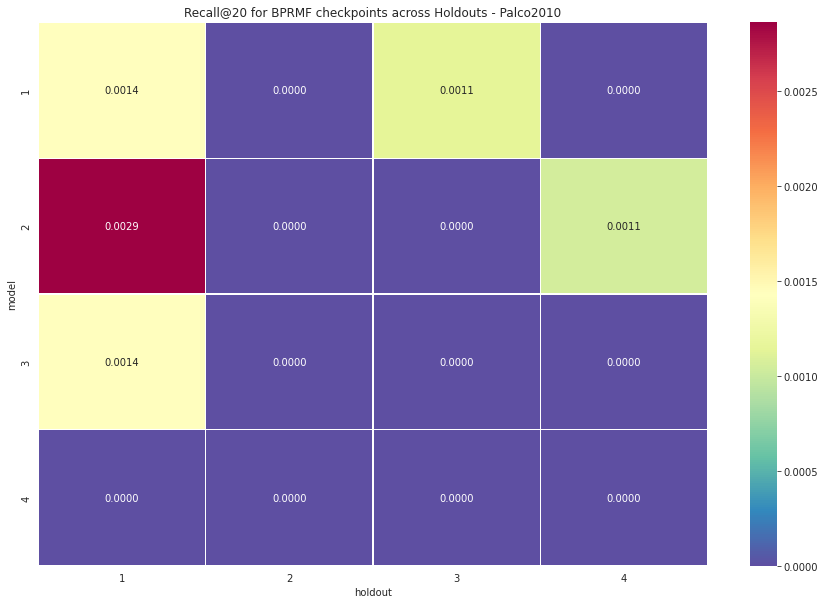

In [13]:
recall_heatmap(df,
               round_point=4,
    title='Recall@20 for BPRMF checkpoints across Holdouts - Palco2010',
    filepath='images/heatmaps/palco_2010_dump/sample_palco2010 month_bucket BPRMF heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [14]:
arecall = avg_recall(df)
arecall

0.000357653791130186

In [15]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([0.001430615164520744, 0.0, -0.0004768717215069146], 0.00031791448100460976)

In [16]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.0003666884948011183

In [17]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/palco_2010_dump/sample_palco2010 month_bucket BPRMF training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/palco_2010_dump/sample_palco2010 month_bucket BPRMF eval time.joblib')

['output/palco_2010_dump/sample_palco2010 month_bucket BPRMF eval time.joblib']

In [19]:
import pandas as pd
import numpy as np

def avg_recall(results_matrix):
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Díaz-Rodriguez et al. 2018
    diff = []
    n_checkpoints = results_matrix.shape[0]
    for i in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        for j in range(i):
            Rij = results_matrix.iloc[i,j] # get models performances' on previous holdouts
            Rjj = results_matrix.iloc[j,j] # get models performances' on their closest holdouts (diagonal)
            # print(Rij, Rjj)
            diff.append( Rij - Rjj ) # future models performances' - performances' of models closest to holdouts (diagonal)
            # print(diff)
    BWT = sum(diff) / ( n_checkpoints*(n_checkpoints-1) / 2 ) # store average BWT for model
    return BWT, diff # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

In [20]:
df = pd.read_csv('output/palco_2010_dump/sample_palco2010 month_bucket BPRMF results.csv')

In [21]:
avg_recall(df).round(6)

0.000358

In [22]:
BWT, diff = compute_BWT(df)
print( BWT )

0.0


In [30]:
compute_FWT(df).round(6)

0.000367